# 9.9 语义分割和数据集

在前几节讨论的目标检测问题中，我们一直使用方形边界框来标注和预测图像中的目标。本节将探讨语义分割（semantic segmentation）问题，它关注如何将图像分割成属于不同语义类别的区域。值得一提的是，这些语义区域的标注和预测都是像素级的。图9.10展示了语义分割中图像有关狗、猫和背景的标签。可以看到，与目标检测相比，语义分割标注的像素级的边框显然更加精细。

## 9.9.1 图像分割和实例分割

计算机视觉领域还有2个与语义分割相似的重要问题，即图像分割（image segmentation）和实例分割（instance segmentation）。我们在这里将它们与语义分割简单区分一下。

* 图像分割将图像分割成若干组成区域。这类问题的方法通常利用图像中像素之间的相关性。它在训练时不需要有关图像像素的标签信息，在预测时也无法保证分割出的区域具有我们希望得到的语义。以图9.10的图像为输入，图像分割可能将狗分割成两个区域：一个覆盖以黑色为主的嘴巴和眼睛，而另一个覆盖以黄色为主的其余部分身体。
* 实例分割又叫同时检测并分割（simultaneous detection and segmentation）。它研究如何识别图像中各个目标实例的像素级区域。与语义分割有所不同，实例分割不仅需要区分语义，还要区分不同的目标实例。如果图像中有两只狗，实例分割需要区分像素属于这两只狗中的哪一只。

## 9.9.2 Pascal VOC2012语义分割数据集

语义分割的一个重要数据集叫作Pascal VOC2012 [1]。为了更好地了解这个数据集，我们先导入实验所需的包或模块。

In [1]:
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

我们先下载这个数据集的压缩包（[下载地址](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar)）。压缩包大小是2 GB左右，下载需要一定时间。下载后解压得到`VOCdevkit/VOC2012`文件夹，然后将其放置在`data`文件夹下。

```sh
$ wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
```

In [2]:
!ls /home/mylady/Datasets/VOCdevkit

VOC2012


进入`../../data/VOCdevkit/VOC2012`路径后，我们可以获取数据集的不同组成部分。其中`ImageSets/Segmentation`路径包含了指定训练和测试样本的文本文件，而`JPEGImages`和`SegmentationClass`路径下分别包含了样本的输入图像和标签。这里的标签也是图像格式，其尺寸和它所标注的输入图像的尺寸相同。标签中颜色相同的像素属于同一个语义类别。下面定义`read_voc_images`函数将输入图像和标签读进内存。

In [5]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
def read_voc_images(root="/home/mylady/Datasets/VOCdevkit/VOC2012", 
                    is_train=True, max_num=None):
    
    txt_fname = '%s/ImageSets/Segmentation/%s' % (root,  
                                                  'train.txt' if is_train else 'val.txt')
    
    with open(txt_fname, 'r') as f:
        images = f.read().split()
        
    if max_num is not None:
        images = images[:min(max_num, len(images))]
        
    features, labels = [None] * len(images), [None] * len(images)
    
    for i, fname in tqdm(enumerate(images)):
        features[i] = Image.open('%s/JPEGImages/%s.jpg' % (root, fname)).convert("RGB")
        labels[i] = Image.open('%s/SegmentationClass/%s.png' % (root, fname)).convert("RGB")
    
    return features, labels # PIL image


# voc_dir = "../../data/VOCdevkit/VOC2012"
voc_dir = '/home/mylady/Datasets/VOCdevkit/VOC2012'
train_features, train_labels = read_voc_images(voc_dir, max_num=100)

100it [00:00, 608.40it/s]


我们画出前5张输入图像和它们的标签。在标签图像中，白色和黑色分别代表边框和背景，而其他不同的颜色则对应不同的类别。

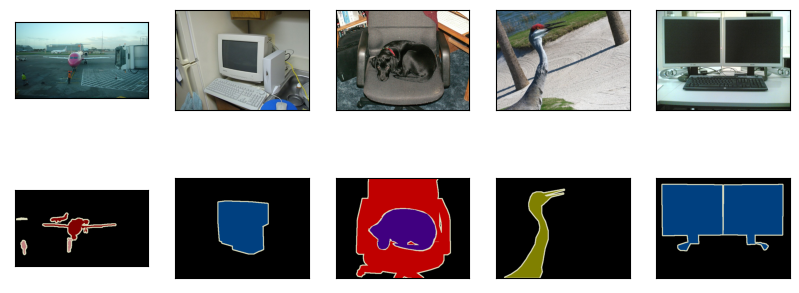

In [6]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

接下来，我们列出标签中每个RGB颜色的值及其标注的类别。

In [7]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
VOC_COLORMAP = [[0, 0, 0], 
                [128, 0, 0], 
                [0, 128, 0], 
                [128, 128, 0],
                
                [0, 0, 128], 
                [128, 0, 128], 
                [0, 128, 128], 
                [128, 128, 128],
                
                [64, 0, 0], 
                [192, 0, 0], 
                [64, 128, 0], 
                [192, 128, 0],
                
                [64, 0, 128], 
                [192, 0, 128], 
                [64, 128, 128], 
                [192, 128, 128],
                
                [0, 64, 0], 
                [128, 64, 0], 
                [0, 192, 0], 
                [128, 192, 0],
                [0, 64, 128]
               ]


# 本函数已保存在d2lzh_pytorch中方便以后使用
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

有了上面定义的两个常量以后，我们可以很容易地查找标签中每个像素的类别索引。

In [8]:
colormap2label = torch.zeros(256 ** 3, dtype=torch.uint8)


for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

    
# 本函数已保存在d2lzh_pytorch中方便以后使用
def voc_label_indices(colormap, colormap2label):
    """
    convert colormap (PIL image) to colormap2label (uint8 tensor).
    """
    colormap = np.array(colormap.convert("RGB")).astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256+ colormap[:, :, 2])
    
    return colormap2label[idx]

例如，第一张样本图像中飞机头部区域的类别索引为1，而背景全是0。

In [9]:
y = voc_label_indices(train_labels[0], colormap2label)


y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]], dtype=torch.uint8),
 'aeroplane')

### 9.9.2.1 预处理数据

在之前的章节中，我们通过缩放图像使其符合模型的输入形状。然而在语义分割里，这样做需要将预测的像素类别重新映射回原始尺寸的输入图像。这样的映射难以做到精确，尤其在不同语义的分割区域。为了避免这个问题，我们将图像裁剪成固定尺寸而不是缩放。具体来说，我们使用图像增广里的随机裁剪，并对输入图像和标签裁剪相同区域。

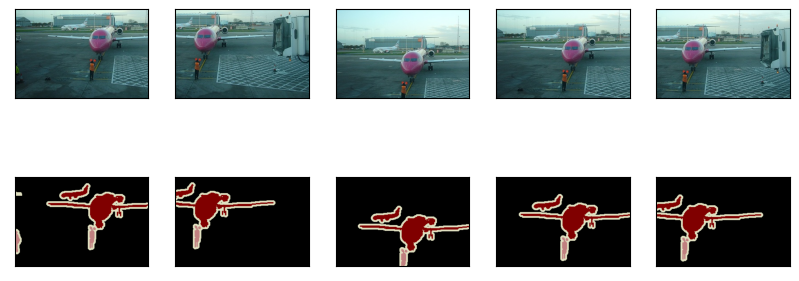

In [10]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
def voc_rand_crop(feature, label, height, width):
    """
    Random crop feature (PIL image) and label (PIL image).
    """
    
    i, j, h, w = torchvision.transforms.RandomCrop.get_params(
        feature,
        output_size=(height, width)
    )
    
    feature = torchvision.transforms.functional.crop(feature, i, j, h, w)
    label = torchvision.transforms.functional.crop(label, i, j, h, w)    

    return feature, label


imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

    
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### 9.9.2.2 自定义语义分割数据集类

我们通过继承PyTorch提供的`Dataset`类自定义了一个语义分割数据集类`VOCSegDataset`。通过实现`__getitem__`函数，我们可以任意访问数据集中索引为`idx`的输入图像及其每个像素的类别索引。由于数据集中有些图像的尺寸可能小于随机裁剪所指定的输出尺寸，这些样本需要通过自定义的`filter`函数所移除。此外，我们还对输入图像的RGB三个通道的值分别做标准化。

In [11]:
# 本函数已保存在d2lzh_pytorch中方便以后使用
class VOCSegDataset(torch.utils.data.Dataset):
    
    def __init__(self, is_train, crop_size, voc_dir, colormap2label, max_num=None):
        """
        crop_size: (h, w)
        """
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.tsf = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=self.rgb_mean, 
                                             std=self.rgb_std)
        ])
        
        self.crop_size = crop_size # (h, w)
        features, labels = read_voc_images(root=voc_dir, 
                                           is_train=is_train, 
                                           max_num=max_num)
        self.features = self.filter(features) # PIL image
        self.labels = self.filter(labels)     # PIL image
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' valid examples')

    def filter(self, imgs):
        return [img for img in imgs if (
            img.size[1] >= self.crop_size[0] and
            img.size[0] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx],
                                       self.labels[idx],
                                       *self.crop_size)
        
        # float32 tensor
        return (self.tsf(feature), 
                voc_label_indices(label, self.colormap2label)) # uint8 tensor

    def __len__(self):
        return len(self.features)

### 9.9.2.3 读取数据集

我们通过自定义的`VOCSegDataset`类来分别创建训练集和测试集的实例。假设我们指定随机裁剪的输出图像的形状为$320\times 480$。下面我们可以查看训练集和测试集所保留的样本个数。

In [12]:
crop_size = (320, 480)
max_num = 100



voc_train = VOCSegDataset(True, 
                          crop_size, 
                          voc_dir, 
                          colormap2label, 
                          max_num)


voc_test = VOCSegDataset(False,
                         crop_size, 
                         voc_dir, 
                         colormap2label,
                         max_num)

100it [00:00, 527.71it/s]


read 75 valid examples


100it [00:00, 656.58it/s]

read 77 valid examples


设批量大小为64，分别定义训练集和测试集的迭代器。

In [13]:
batch_size = 64
num_workers = 0 if sys.platform.startswith('win32') else 4


train_iter = torch.utils.data.DataLoader(voc_train, 
                                         batch_size, 
                                         shuffle=True,
                                         drop_last=True, 
                                         num_workers=num_workers
                                        )


test_iter = torch.utils.data.DataLoader(voc_test, 
                                        batch_size, 
                                        drop_last=True,
                                        num_workers=num_workers
                                       )

打印第一个小批量的类型和形状。不同于图像分类和目标识别，这里的标签是一个三维数组。

In [14]:
for X, Y in train_iter:
    print(X.dtype, X.shape)
    print(y.dtype, Y.shape)
    break

torch.float32 torch.Size([64, 3, 320, 480])
torch.uint8 torch.Size([64, 320, 480])


## 小结

* 语义分割关注如何将图像分割成属于不同语义类别的区域。
* 语义分割的一个重要数据集叫作Pascal VOC2012。
* 由于语义分割的输入图像和标签在像素上一一对应，所以将图像随机裁剪成固定尺寸而不是缩放。

## 练习

* 回忆9.1节（图像增广）中的内容。哪些在图像分类中使用的图像增广方法难以用于语义分割？

##  参考文献

[1] Pascal VOC2012数据集。http://host.robots.ox.ac.uk/pascal/VOC/voc2012/